# Modules Associated with Time Point

**Created**: 20 October 2021

## Environment

In [1]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

Loading required namespace: patchwork



In [2]:
library(tidyverse)
library(RColorBrewer)
library(patchwork)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Load Data

In [3]:
modules <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.csv")
eigengenes <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.csv", row.names=1)
variance.explained <- read.csv("~/gains_team282/nikhil/expression/gene_expression/variance.explained.csv")

sample.info <- read.table("/nfs/team282/data/gains_team282/Sample_info_864.txt") %>%
    dplyr::mutate(supplier_name=gsub("^GA", "", supplier_name)) %>%
    dplyr::filter(supplier_name %in% rownames(eigengenes)) %>%
    dplyr::mutate(Time.Point=as.numeric(gsub("^.*_", "", supplier_name)))

rownames(sample.info) <- sample.info$supplier_name
sample.info <- sample.info[rownames(eigengenes),]

## Association with Time Point between D1-D5 Pairs

Some patients have provided samples at both D1 and D5. We can test if eigengenes are different between these timepoints.

I ran a Wilcox paired test with a two-sided alternative to test for a difference in module eigengenes across the twopoints. The p-values were adjusted using a Benjamini-Hochberg FDR correction.

In [4]:
d1.d5.pair <- sample.info %>%
  dplyr::select(GAinSID, Time.Point, supplier_name) %>%
  tidyr::spread(Time.Point, supplier_name) %>%
  dplyr::filter(!is.na(`1`) & !is.na(`5`)) %>%
  dplyr::select(GAinSID, D1=`1`, D5=`5`) %>%
  tidyr::gather("Time.Point", "Sample", -GAinSID)

d1.d5.vars <- eigengenes[d1.d5.pair$Sample,] %>%
  cbind(., d1.d5.pair) %>%
  as.data.frame() %>%
  dplyr::select(-Sample)

test.results <- list()
test.results[["P.Value"]] <- list()
test.results[["Median.Delta"]] <- list()

for (eigengene in variance.explained$Module) {

  paired.data <- d1.d5.vars %>%
    dplyr::select(one_of(eigengene), Time.Point, GAinSID) %>%
    tidyr::spread(Time.Point, eigengene) %>%
    dplyr::mutate(Delta=D5 - D1)
  
  test.results[["P.Value"]][[eigengene]] <- wilcox.test(paired.data$D1, paired.data$D5, paired=TRUE, alternative="two.sided")$p.value
  test.results[["Median.Delta"]][[eigengene]] <- median(paired.data$Delta)
}

associated.eigengenes <- lapply(test.results, unlist) %>%
  as.data.frame() %>%
  dplyr::mutate(Eigengene=rownames(.)) %>%
  dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH")) %>%
  dplyr::arrange(desc(abs(Median.Delta))) %>%
  dplyr::mutate(Association.Variable="D5 - D1", Association.Variable.Type="Time Point", Statistic.Type="Median Difference") %>%
  dplyr::select(Eigengene, Association.Variable, Association.Variable.Type, Statistic=Median.Delta, Statistic.Type, P.Value, Adjusted.P.Value)

## Association with Time Point between D1-D3 and D3-D5 Pairs

Some patients have provided samples at D1 and D3. Some patients have provided samples at D3 and D5. We can test if eigengenes are different between these timepoints. Basically, are any eigengenes associated with change over any two day period?

I separated samples into pairs - each pair is either a D1-D3 pair or a D3-D5 pair. I ran a Wilcox paired test with a two-sided alternative to test for a difference in module eigengenes across the twopoints. The p-values were adjusted using a Benjamini-Hochberg FDR correction.

In [5]:
d1.d3.pair <- sample.info %>%
  dplyr::select(GAinSID, Time.Point, supplier_name) %>%
  tidyr::spread(Time.Point, supplier_name) %>%
  dplyr::filter(!is.na(`1`) & !is.na(`3`)) %>%
  dplyr::select(GAinSID, D1=`1`, D3=`3`) %>%
  tidyr::gather("Time.Point", "Sample", -GAinSID)

d1.d3.vars <- eigengenes[d1.d3.pair$Sample,] %>%
  cbind(., d1.d3.pair) %>%
  as.data.frame() %>%
  dplyr::select(-Sample)

d3.d5.pair <- sample.info %>%
  dplyr::select(GAinSID, Time.Point, supplier_name) %>%
  tidyr::spread(Time.Point, supplier_name) %>%
  dplyr::filter(!is.na(`3`) & !is.na(`5`)) %>%
  dplyr::select(GAinSID, D3=`3`, D5=`5`) %>%
  tidyr::gather("Time.Point", "Sample", -GAinSID)

d3.d5.vars <- eigengenes[d3.d5.pair$Sample,] %>%
  cbind(., d3.d5.pair) %>%
  as.data.frame() %>%
  dplyr::select(-Sample)

In [6]:
test.results <- list()
test.results[["P.Value"]] <- list()
test.results[["Median.Delta"]] <- list()

for (eigengene in variance.explained$Module) {
    
    paired.data <- dplyr::bind_rows(
        d1.d3.vars %>%
            dplyr::select(one_of(eigengene), Time.Point, GAinSID) %>%
            tidyr::spread(Time.Point, eigengene) %>%
            dplyr::select(GAinSID, D.Start=D1, D.End=D3),
      d3.d5.vars %>%
            dplyr::select(one_of(eigengene), Time.Point, GAinSID) %>%
            tidyr::spread(Time.Point, eigengene) %>%
            dplyr::select(GAinSID, D.Start=D3, D.End=D5)
    ) %>%
    dplyr::mutate(Delta=D.End - D.Start)
  
  test.results[["P.Value"]][[eigengene]] <- wilcox.test(paired.data$D.Start, paired.data$D.End, paired=TRUE, alternative="two.sided")$p.value
  test.results[["Median.Delta"]][[eigengene]] <- median(paired.data$Delta)
}

associated.eigengenes <- lapply(test.results, unlist) %>%
  as.data.frame() %>%
  dplyr::mutate(Eigengene=rownames(.)) %>%
  dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH")) %>%
  dplyr::arrange(desc(abs(Median.Delta))) %>%
  dplyr::mutate(Association.Variable="D_End - D_Start", Association.Variable.Type="Time Point", Statistic.Type="Median Difference") %>%
  dplyr::select(Eigengene, Association.Variable, Association.Variable.Type, Statistic=Median.Delta, Statistic.Type, P.Value, Adjusted.P.Value)

write.csv(associated.eigengenes, "~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.time.point.association.csv")

In [7]:
head(associated.eigengenes)

,Eigengene,Association.Variable,Association.Variable.Type,Statistic,Statistic.Type,P.Value,Adjusted.P.Value
,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
ME_44,ME_44,D_End - D_Start,Time Point,-0.02186283,Median Difference,1.944700e-14,2.061382e-13
ME_49,ME_49,D_End - D_Start,Time Point,-0.02089262,Median Difference,2.182418e-15,4.626727e-14
ME_75,ME_75,D_End - D_Start,Time Point,0.01783991,Median Difference,3.607715e-17,1.122721e-15
ME_45,ME_45,D_End - D_Start,Time Point,-0.01760816,Median Difference,2.848614e-19,3.019530e-17
ME_8,ME_8,D_End - D_Start,Time Point,-0.01733125,Median Difference,2.720991e-17,1.122721e-15
ME_43,ME_43,D_End - D_Start,Time Point,-0.01699712,Median Difference,2.329278e-09,7.481924e-09


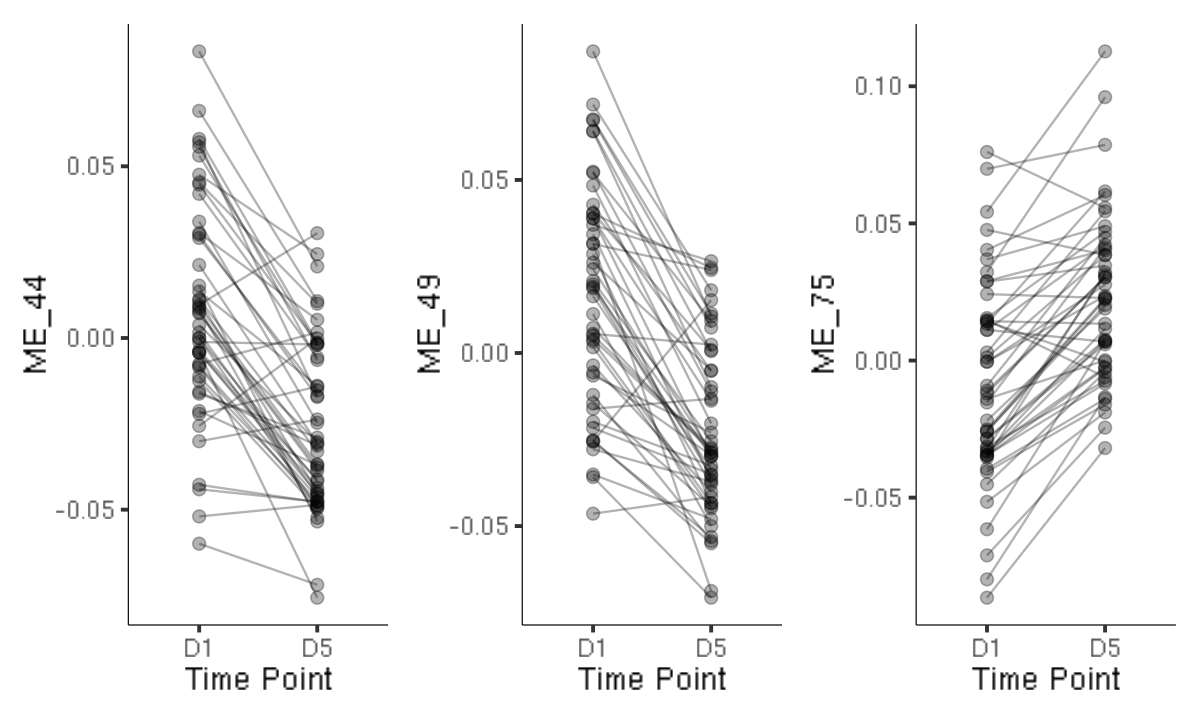

In [9]:
plots <- lapply(c("ME_44", "ME_49", "ME_75"), function(eigengene) {
  ggplot(d1.d5.vars, aes_string(x="Time.Point", y=eigengene, group="GAinSID")) +
    geom_line(alpha=0.3) +
    geom_point(size=I(3), alpha=0.3) +
    xlab("Time Point") +
    ggplot_theme
})

options(repr.plot.width=10, repr.plot.height=6)
wrap_plots(plots)
ggsave("04_Expression/results/eigengene_association_with_time_point.svg", width=10, height=6)